# Processing GEM2 and magnaprobe data

**Adam Steer**

**May 2022**

From Magnaprobe and GEM2 measurements we get snow depth at about 1-2m along track resolotion, and combined snow + ice depth at some unknown resolution.

From these datasets, we need to generate snow depth (done!), ice thickness, draft and freeboard.

For ice thickness, draft and freeboard we rely on some assumptions about hydrostatic equilibrium and density of snow and ice. Using those, we model freeboard and draft using snow depths from the magnaprobe and combined snow and ice thickness from the GEM2 as constraints.

This notebook uses the approach:

- collect drift-corrected magnaprobe data into a set of point geometries
- collect drift-corrected GEM2 data into a set of point geometries
- test each magnaprobe point and find GEM2 data within 2.5 m radius (5m diameter)
- collect the median of GEM2 points found in that radius
- subtract magnaprobe snowdepth from median of GEM2 points
- use median GEM2 data, magnaprobe snow depth, and snow/ice density observations to compute ice thickness, draft and freeboard

This will result in a lot of overlapping data - for example two consecutive magnaprobe points are very likely to have overlap in their region where GEM2 data are collected. Given that GEM2 has a footprint of approximately 4 m diamter, this simple relfects the reality of how the measurements are collected. If needed, spatial filtering can be done later.


In [1]:
## import all the things we need

import os
import numpy as np

import pandas as pd

from matplotlib import pyplot as plt

from shapely import geometry


In [2]:
# declare a function to compute freeboard
def find_fi(zi, zs, dwater, dice, dsnow):
    
    #derived by Claire Trenham, CSIRO, and Adam Steer.
    fi = (((dwater - dice) * zi) - dsnow * zs) / dwater
    
    return fi

### Start loading MP data

In [3]:
mp_data = pd.read_csv("/mnt/documents/Q1/P4-10032021/magnaprobe/MPdata-driftcorrected-datefixed.csv",
                      skiprows = 10)

In [4]:
mp_data

timestamp       easting       northing  snowdepth
0     10-03-2021T07:28:00.85  1.088992e+06 -218643.029725    -0.0001
1     10-03-2021T07:28:03.27  1.088992e+06 -218643.238143     1.2100
2      10-03-2021T07:28:09.6  1.088991e+06 -218642.973287    -0.0001
3     10-03-2021T07:28:16.65  1.088992e+06 -218643.288948     0.2192
4     10-03-2021T07:39:48.78  1.088998e+06 -218645.887661     0.1458
...                      ...           ...            ...        ...
1461  10-03-2021T08:32:15.84  1.088994e+06 -218643.239654     0.2234
1462  10-03-2021T08:32:21.23  1.088994e+06 -218643.528849     1.2100
1463  10-03-2021T08:32:23.07  1.088994e+06 -218643.351429     1.2100
1464  10-03-2021T08:32:24.93  1.088994e+06 -218643.298548     1.2100
1465  10-03-2021T08:58:23.93  1.088998e+06 -218621.219450     0.0010

[1466 rows x 4 columns]

In [5]:
# generate a list of tuple coordinate pairs
xypairs = list(zip(mp_data["easting"].values-5, mp_data["northing"].values))

In [6]:
xypairs[0]

(1088987.3204452526, -218643.02972462415)

In [7]:
# make geometries from each point
mp_points = []

for pair in xypairs:
    mp_points.append(geometry.Point(pair[0], pair[1]))

In [8]:
# make buffered points, with 24 sided 'circles'

mp_buffers = []
for point in mp_points:
    mp_buffers.append(point.buffer(2.5, resolution=36))

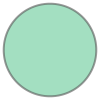

In [9]:
mp_buffers[0]

### Read and geometry-ify GEM2 data

In [10]:
gem2_data = pd.read_csv("/mnt/documents/Q1/P4-10032021/GEM2/GEM2data-driftcorrected.csv",
                      skiprows = 10)

In [11]:
gem2_data[0:5]

time   record_id       easting       northing   xc  \
0  2021-11-03T07:37:36.515625           3  1.088994e+06 -218642.016960  0.0   
1  2021-11-03T07:37:36.617187           4  1.088994e+06 -218642.016395  0.0   
2  2021-11-03T07:37:36.710937           5  1.088994e+06 -218642.018219  0.0   
3  2021-11-03T07:37:36.812500           6  1.088994e+06 -218642.017654  0.0   
4  2021-11-03T07:37:36.914062           7  1.088994e+06 -218642.018990  0.0   

    yc  f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
0  0.0         0.831          0.771           0.766           0.757   
1  0.0         0.751          0.727           0.735           0.759   
2  0.0         0.695          0.722           0.737           0.754   
3  0.0         0.674          0.750           0.766           0.749   
4  0.0         0.682          0.766           0.751           0.739   

    f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i   f18330Hz_hcp_q  \
0           0.773           0.748            0.763            0.739   
1           0.766           0.748            0.764            0.738   
2           0.771           0.751            0.762            0.738   
3           0.770           0.756            0.764            0.738   
4           0.765           0.753            0.765            0.738   

    f63030Hz_hcp_i  f63030Hz_hcp_q  
0            0.756             nan  
1            0.755             nan  
2            0.755             nan  
3            0.755             nan  
4            0.755             nan

In [12]:
gem2_data.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

### Check that the coordinates line up!

Added a -5m translation to Magnaprobe data eastings so it lines up. Northing seems OK

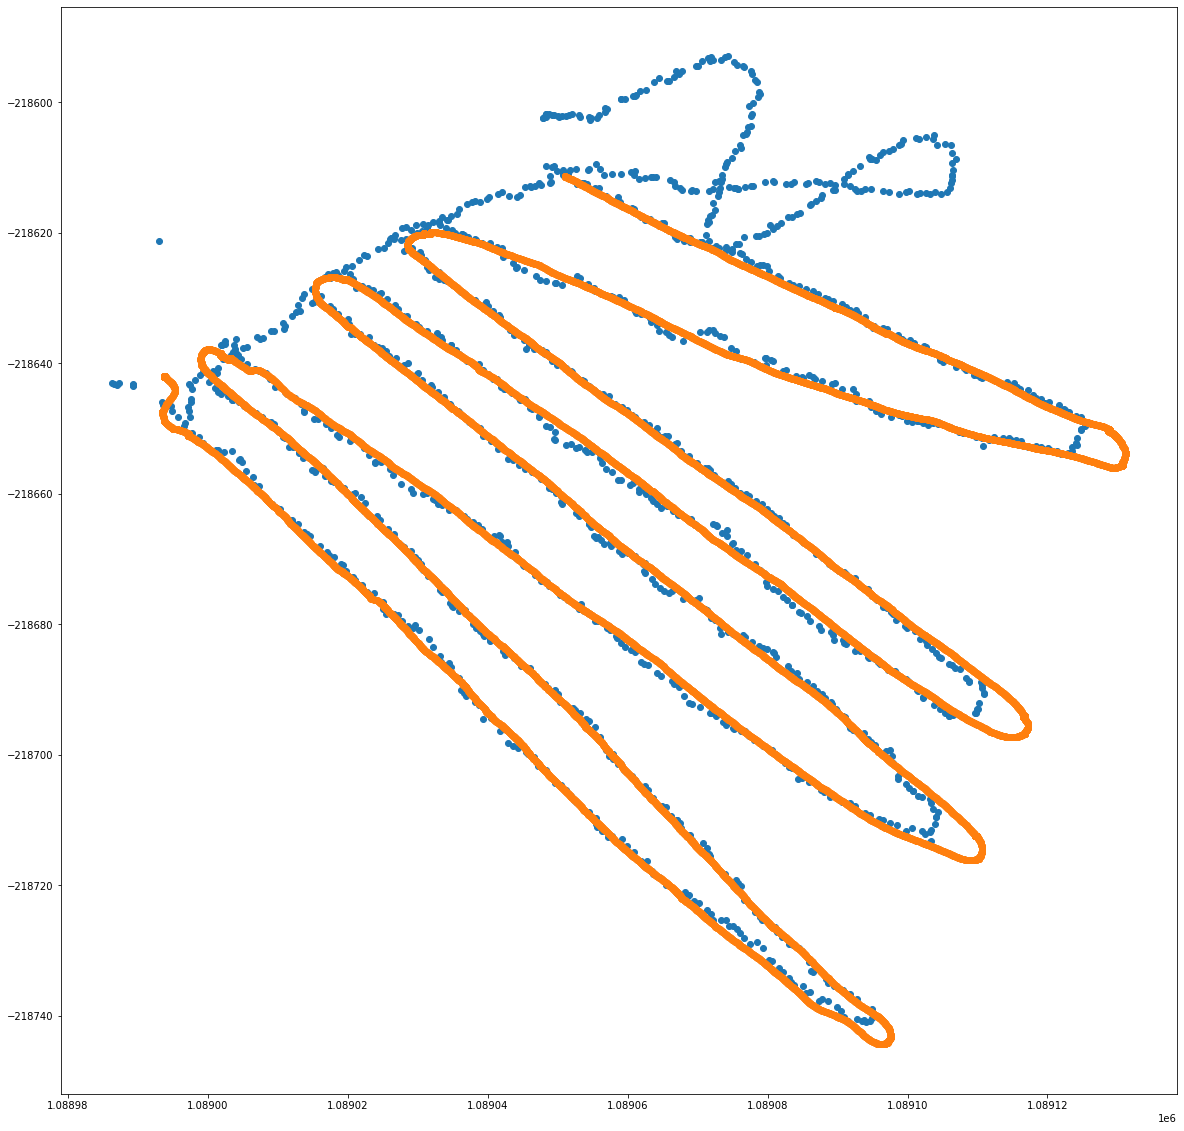

In [13]:
fig = plt.figure(figsize=(20,20))
plt.scatter(mp_data["easting"].values-5, mp_data["northing"].values)
plt.scatter(gem2_data["easting"].values, gem2_data["northing"].values)

In [14]:
len(gem2_data["easting"].values)

23262

In [15]:
gem2_xypairs = list(zip(gem2_data["easting"].values, gem2_data["northing"].values))

In [16]:
# make geometries from each point
gem2_points = []

for pair in gem2_xypairs:
    gem2_points.append(geometry.Point(pair[0], pair[1]))

In [17]:
len(gem2_points)

23262

## Select GEM2 data points to use

- find GEM2 points within the buffer from MP points
- collect GEM2 observations matching those points
- compute the median of GEM2 observations
- assemble an array of MP and matching median GEM2 observations

In [18]:
mp_ind = 0
gem2_ind = 0
bufferpoints = []
collected_points = []

# iterate over MP buffers
for buffer in mp_buffers:
    #print("buffer {}".format(mp_ind))
    #then over gem2 points
    for thispoint in gem2_points:
        
        #if the buffer contains the point
        if buffer.contains(thispoint):
            
            #capture the index of each point the buffer contains
            bufferpoints.append(gem2_ind)
        
        gem2_ind += 1
    gem2_ind = 0
    collected_points.append([mp_ind, bufferpoints])
    bufferpoints = []
    mp_ind += 1

In [19]:
collected_points

[[0, []],
 [1, []],
 [2, []],
 [3, []],
 [4,
  [340,
   341,
   342,
   343,
   344,
   345,
   346,
   347,
   348,
   349,
   350,
   351,
   352,
   353,
   354,
   355,
   356,
   357,
   358,
   359,
   360,
   361,
   362,
   363,
   364,
   365,
   366,
   367,
   368,
   369,
   370,
   371,
   372,
   373,
   374,
   375,
   376,
   377,
   378,
   379,
   380,
   381,
   382,
   383,
   384,
   385,
   386,
   387,
   388,
   389,
   390,
   391,
   392,
   393,
   394,
   395,
   396,
   397,
   398,
   399,
   400,
   401,
   402,
   403,
   404,
   405,
   406,
   407,
   408,
   409,
   410,
   411,
   412,
   413,
   414,
   415,
   416,
   417,
   418,
   419,
   420,
   421,
   422,
   423,
   424,
   425,
   426,
   427,
   428,
   429,
   430,
   431,
   432,
   433,
   434,
   435,
   436,
   437,
   438,
   439,
   440,
   441]],
 [5,
  [347,
   348,
   349,
   350,
   351,
   352,
   353,
   354,
   355,
   356,
   357,
   358,
   359,
   360,
   361,
   362,
   3

In [1]:
gem2_data[" f5310Hz_hcp_i"][np.array(collected_points[4][1])]

NameError: name 'gem2_data' is not defined

In [1]:
np.median(gem2_data[" f5310Hz_hcp_i"][np.array(collected_points[4][1])])

NameError: name 'np' is not defined

In [ ]:
np.median(gem2_data[" f5310Hz_hcp_i"][np.array(collected_points[4][1])])

In [22]:
#generate a list of MP data indexes and GEM2 median measurements
median_gem2 = []

for datapoint in collected_points:
    if len(datapoint[1]) > 0:
        thismedian = np.median(gem2_data[" f5310Hz_hcp_i"][datapoint[1]])

    else:
        thismedian = np.nan
        
    the_array = [datapoint[0], thismedian]
    median_gem2.append(the_array)

In [23]:
median_gem2[0:5]

[[0, nan], [1, nan], [2, nan], [3, nan], [4, 0.8145]]

In [24]:
mp_inds = [pair[0] for pair in median_gem2]
mp_inds[0:5]

[0, 1, 2, 3, 4]

In [25]:
gem2_zi = [pair[1] for pair in median_gem2]

In [26]:
len(mp_inds)

1466

In [27]:
len(mp_data["snowdepth"])

1466

In [28]:
zi = gem2_zi - mp_data["snowdepth"].values

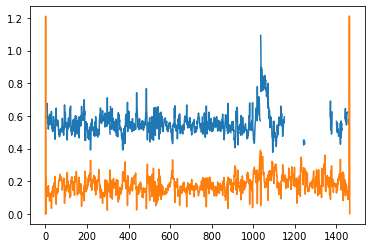

In [29]:
plt.plot(zi)
plt.plot(mp_data["snowdepth"].values)

In [30]:
#(zi, zs, dwater, dice, dsnow)
freeboards = find_fi(zi,mp_data["snowdepth"].values, 1027, 915, 315)

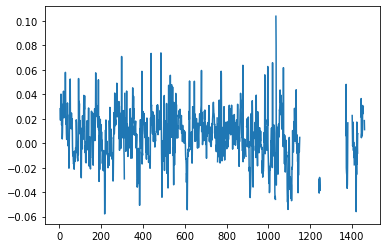

In [31]:
plt.plot(freeboards)

In [32]:
np.nanmedian(freeboards)

0.006704868549172346

In [33]:
np.nanmean(freeboards)

0.0057156895210081

In [34]:
drafts = freeboards - zi

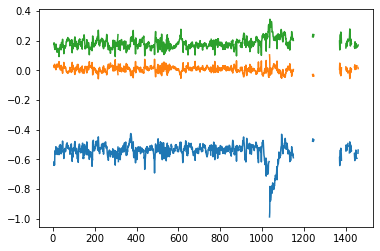

In [35]:
plt.plot(drafts)
plt.plot(freeboards)
plt.plot(freeboards + mp_data["snowdepth"].values)

In [36]:
np.nanmean(zi)

0.5518046861924687

In [37]:
np.nanmedian(zi)

0.5435

In [38]:
elevation = freeboards + mp_data["snowdepth"].values

In [40]:
#https://stackoverflow.com/questions/6811183/rolling-window-for-1d-arrays-in-numpy

from numpy.lib.stride_tricks import sliding_window_view

In [41]:
# generate 5 element windows for estimating roughness
roughnesswindows = sliding_window_view(elevation, 5)

In [42]:
# compute roughness, using standard deviation of the 5 element window
roughness = [np.std(window) for window in roughnesswindows]

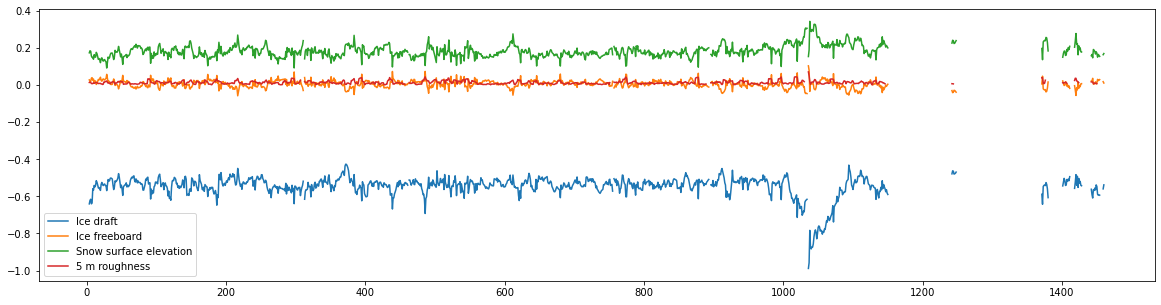

In [43]:
fig = plt.figure(figsize=(20,5))

plt.plot(drafts, label = "Ice draft")
plt.plot(freeboards, label = "Ice freeboard")
plt.plot(freeboards + mp_data["snowdepth"].values, label = "Snow surface elevation")
plt.plot(roughness, label = "5 m roughness")
plt.legend()
ax = plt.gca()

## Check distance between magnaprobe samples

get difference between array elements in X and Y coordinates, do some Pythagoras to get an idea of the magnaprobe observation step size

In [44]:
stepX = np.diff(mp_data["easting"].values-5)

In [45]:
stepY = np.diff(mp_data["northing"].values)

In [46]:
point2point = np.sqrt(stepX**2 + stepY**2)

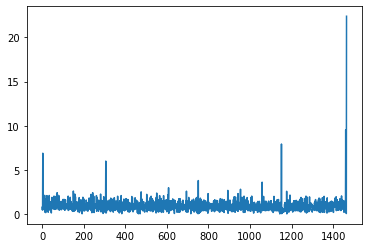

In [47]:
plt.plot(point2point)

In [48]:
# mean distance between points
np.mean(point2point)

0.9396646349589997

In [49]:
# median of distance between points
np.median(point2point)

0.8335321524567437

In [65]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

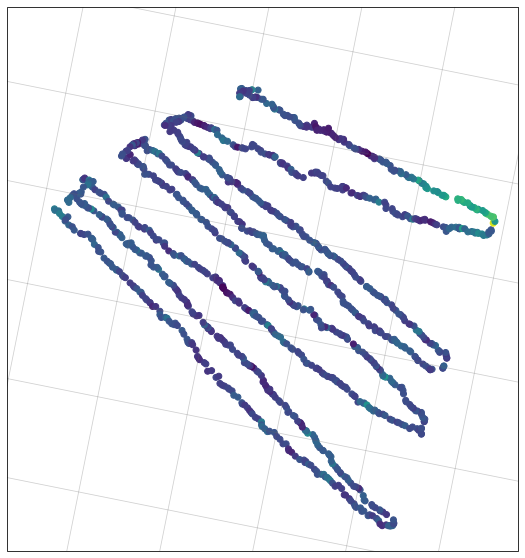

In [74]:
fig = plt.figure(figsize=(10,10))

mapproj = ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 )

ax = plt.axes(projection= mapproj)


plt.scatter(mp_data["easting"].values-5, mp_data["northing"].values, c=zi,
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ))
#cbar = plt.colorbar()
#cbar.set_label("Ice thickness")
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels = False
#gl.right_labels = False

showgridlines = ax.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True, x_inline = False)


In [75]:
## Maybe we could filter out too-close obs here... less than 0.4 / 40 cm?